In [80]:
import sys
sys.path.append("../")

In [81]:
from itertools import cycle, islice

In [82]:
from sklearn import mixture
from sklearn import metrics
from sklearn.cluster import KMeans

In [83]:
import numpy as np
from scipy.stats import kde
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [84]:
sns.set(color_codes=True)

In [85]:
def load_data_file(filename):

    with open(filename) as file:
        context = file.read()
        size = len(context)
        arraystr= context[1:size-1]
        arraystr = arraystr.split(',')
        region_means = [float(item) for item in arraystr]
        return region_means

In [86]:
wga_mean_file = "/home/a/ag568/wga_windows_mean_0_GMM.txt"
no_wga_mean_file = "/home/a/ag568/no_wga_windows_mean_0_GMM.txt"
gc_file = "/home/a/ag568/windows_gc_0_GMM.txt"

In [87]:
wga_mu = load_data_file(filename=wga_mean_file)
no_wga_mu = load_data_file(filename=no_wga_mean_file)
gc = load_data_file(filename=gc_file)

In [88]:
assert len(wga_mu) == len(no_wga_mu)
assert len(gc) == len(wga_mu)

In [89]:
print("Size of WGA sample {0}".format(len(wga_mu)))
print("WGA max: {0}".format(max(wga_mu)))
print("WGA min: {0}".format(min(wga_mu)))
print("WGA mean: {0}".format(np.mean(wga_mu)))
print("WGA var: {0}".format(np.var(wga_mu)))

Size of WGA sample 185329
WGA max: 52.13
WGA min: 0.0
WGA mean: 18.00699696215919
WGA var: 100.56252905243802


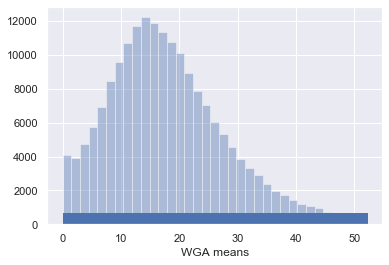

In [90]:
sns.distplot(wga_mu, bins=35, kde=False, rug=True)
plt.xlabel("WGA means")
plt.show()

In [91]:
print("NO-WGA size {0}".format(len(no_wga_mu)))
print("NO-WGA max: {0}".format(max(no_wga_mu)))
print("NO-WGA min: {0}".format(min(no_wga_mu)))
print("NO-WGA mean: {0}".format(np.mean(no_wga_mu)))
print("NO-WGA var: {0}".format(np.var(no_wga_mu)))

NO-WGA size 185329
NO-WGA max: 35.17
NO-WGA min: 0.0
NO-WGA mean: 16.24269504502803
NO-WGA var: 21.10931204078077


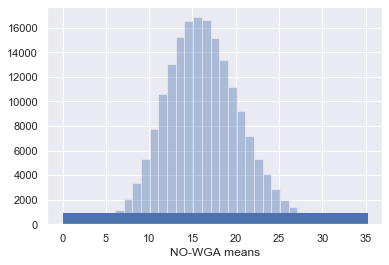

In [92]:
sns.distplot(no_wga_mu, bins=35, kde=False, rug=True)
plt.xlabel("NO-WGA means")
plt.show()

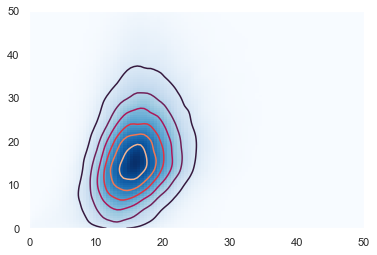

In [93]:
nbins = 100
min_ = 0.0
max_ = 50.0
density=False
plt.hist2d(no_wga_mu, wga_mu,
             bins=[nbins, nbins], cmap='Blues', density=density,
             cmax=1000, cmin=0, alpha=0.99,
             range=((min_, max_), (min_, max_)))

kernel= kde.gaussian_kde(np.vstack([no_wga_mu, wga_mu]))
xi, yi = np.mgrid[min_:max_:nbins*1j,
                    min_:max_:nbins*1j]
zi = kernel(np.vstack([xi.flatten(), yi.flatten()]))
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap='Blues') 
plt.contour(xi, yi, zi.reshape(xi.shape) )

plt.show()

In [114]:
X = np.stack((no_wga_mu, wga_mu), axis=0)
cov = np.cov(X)
pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
print("Pearson correlation: ", pearson)
means = [np.mean(no_wga_mu), np.mean(wga_mu)]

Pearson correlation:  0.26038962327560194


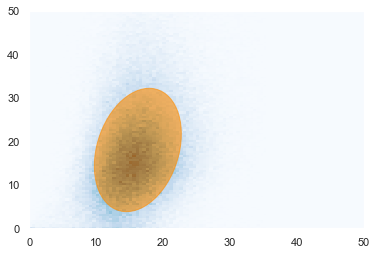

In [95]:
fig, axs = plt.subplots(1, 1)#, figsize=(9, 3))
nbins = 100
min_ = 0.0
max_ = 50.0
density=False
plt.hist2d(no_wga_mu, wga_mu,
             bins=[nbins, nbins], cmap='Blues', density=density,
             cmax=1000, cmin=0, alpha=0.99,
             range=((min_, max_), (min_, max_)))

v, w = linalg.eigh(cov)
    
angle = np.arctan2(w[0][1], w[0][0])
angle = 180. * angle / np.pi  # convert to degrees
v = 2. * np.sqrt(2.) * np.sqrt(v)
ell = mpl.patches.Ellipse(means, v[0], v[1], 180. + angle, color='darkorange')
ell.set_alpha(.6)
axs.add_patch(ell)
plt.show()

In [96]:
print("GC size {0}".format(len(gc)))
print("GC max: {0}".format(max(gc)))
print("GC min: {0}".format(min(gc)))
print("GC mean: {0}".format(np.mean(gc)))
print("GC var: {0}".format(np.var(gc)))

GC size 185329
GC max: 0.93
GC min: 0.0
GC mean: 0.49600305402824174
GC var: 0.01198275802638238


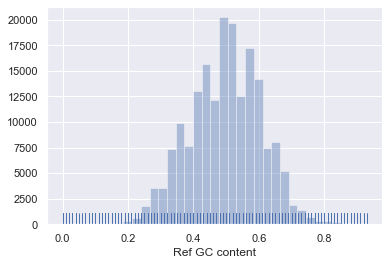

In [97]:
sns.distplot(gc, bins=35, kde=False, rug=True)
plt.xlabel("Ref GC content")
plt.show()

In [98]:
def make_data_array(wga_mu, no_wga_mu, gc, use_ratio, use_gc):
    data = []
    
    if use_ratio and use_gc:
        for no_wga_val, wga_val,gc_val in zip(no_wga_mu, wga_mu, gc):
            data.append([no_wga_val, wga_val, (wga_val + 1)/(no_wga_val + 1), gc_val])
    elif use_ratio:
        for no_wga, wga  in zip(no_wga_mu, wga_mu):
            data.append([no_wga, wga,  (wga + 1)/(no_wga + 1)])
    elif use_gc:
        
        for no_wga_val, wga_val , gc_val in zip(no_wga_mu, wga_mu,  gc):
            data.append([no_wga_val, wga_val, gc_val])
    else:
        
        for no_wga, wga  in zip(no_wga_mu, wga_mu):
            data.append([no_wga, wga ])
        
    return data

In [99]:
def kmeans_clustering(clusters, data):
    for nclusters in clusters:
    
        print("Number of clusters ", nclusters)
        kmeans = KMeans(n_clusters=nclusters)
        kmeans.fit(X=data)
        labels = kmeans.labels_

        calinski_harabasz_score = metrics.calinski_harabasz_score(data, labels)
        print("Calinski score: ", calinski_harabasz_score)
        davies_bouldin_score = metrics.davies_bouldin_score(data, labels)
        print("Davies score: ", davies_bouldin_score)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                          int(max(labels) + 1))))

        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])

        plt.scatter(no_wga_mu, wga_mu,  color=colors[labels])
        plt.xlabel("NO-WGA ")
        plt.ylabel("WGA")
        plt.show()
    

In [100]:
def gmm_clustering(clusters, data):
    
    for nclusters in clusters:
    
        print("Number of clusters ", nclusters)
        gmm = mixture.GaussianMixture(n_components=nclusters,
                                    covariance_type='full')
        gmm.fit(data)
        print("BIC: ", gmm.bic(data))
        labels = gmm.predict(data)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                          int(max(labels) + 1))))


        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])

        plt.scatter(no_wga_mu, wga_mu,  color=colors[labels])
        plt.xlabel("NO-WGA ")
        plt.ylabel("WGA")
        plt.show()
    

In [101]:
N_CLUSTERS = [2, 3, 4, 5]

## Two means 

In [102]:
data = make_data_array(wga_mu=wga_mu, 
                       no_wga_mu=no_wga_mu, gc=None, 
                       use_ratio=False, use_gc=False)

data = np.array(data)

assert data.shape == (len(wga_mu), 2)

### KMeans Clustering

Number of clusters  2
Calinski score:  218429.91720239402
Davies score:  0.798266203547195


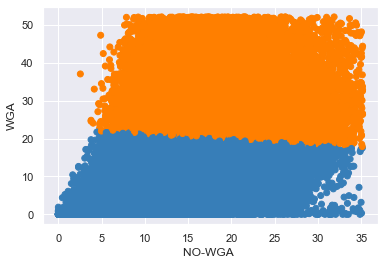

Number of clusters  3
Calinski score:  209601.77502839
Davies score:  0.8693287779367852


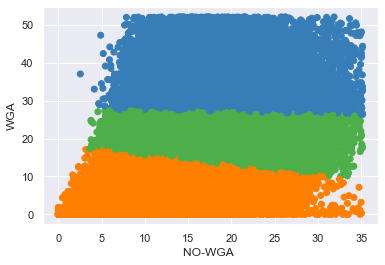

Number of clusters  4
Calinski score:  191989.45384381362
Davies score:  0.9479237763546868


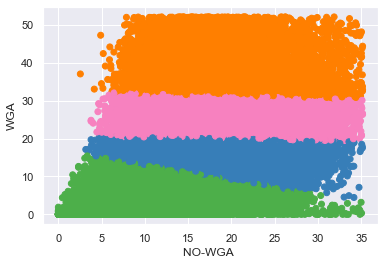

Number of clusters  5
Calinski score:  185128.1818702191
Davies score:  0.898942253633954


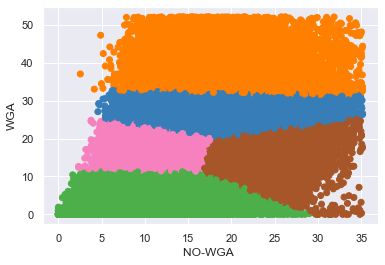

In [103]:
kmeans_clustering(clusters=N_CLUSTERS, data=data)


### GMM Clustering

Number of clusters  2
BIC:  2441183.3616515673


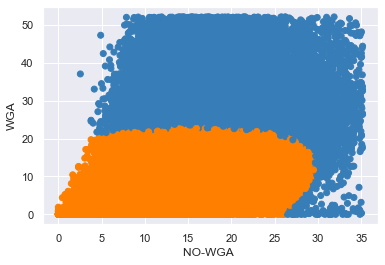

Number of clusters  3
BIC:  2439388.4897071426


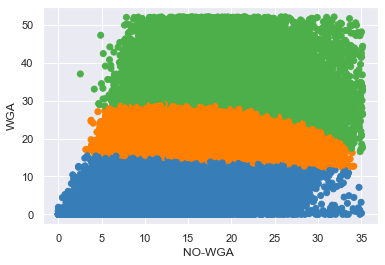

Number of clusters  4
BIC:  2438348.860760715


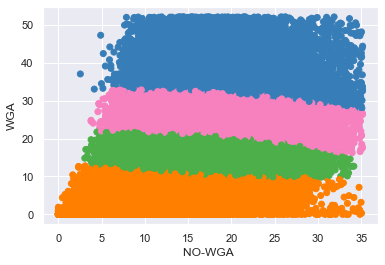

Number of clusters  5
BIC:  2436172.4752455615


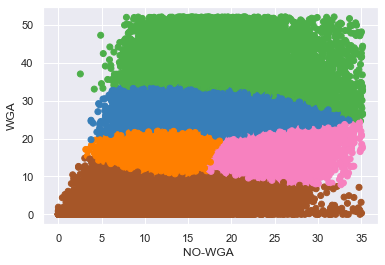

In [104]:
gmm_clustering(clusters=N_CLUSTERS, data=data)


## Two means + Ratio

In [105]:
data = make_data_array(wga_mu=wga_mu, 
                       no_wga_mu=no_wga_mu, gc=None, 
                       use_ratio=True, use_gc=False)

data = np.array(data)

assert data.shape == (len(wga_mu), 3)

### KMeans

Number of clusters  2
Calinski score:  218084.20982207655
Davies score:  0.7994519196385749


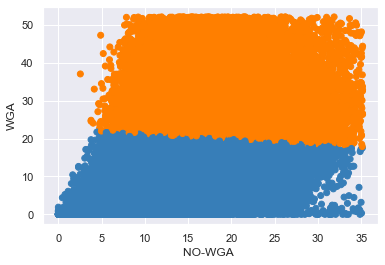

Number of clusters  3
Calinski score:  209070.7319439327
Davies score:  0.8713785309598153


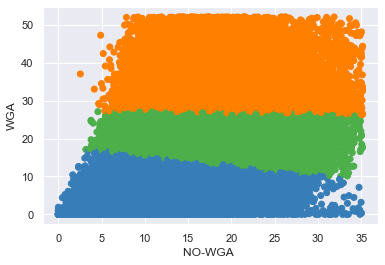

Number of clusters  4
Calinski score:  191411.71088567132
Davies score:  0.9493230885303264


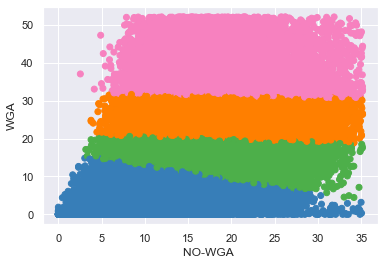

Number of clusters  5
Calinski score:  184581.5702214642
Davies score:  0.8990912617952516


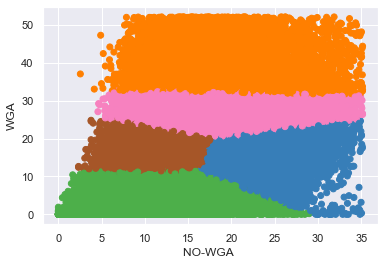

In [106]:
kmeans_clustering(clusters=N_CLUSTERS, data=data)

### GMM

Number of clusters  2
BIC:  2112385.553986553


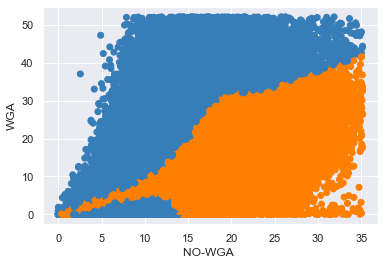

Number of clusters  3
BIC:  1971096.3474582115


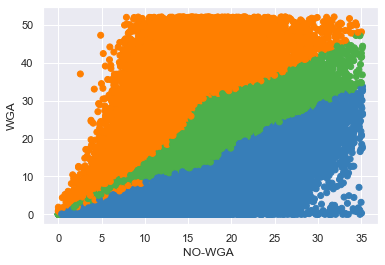

Number of clusters  4
BIC:  1864554.7283753327


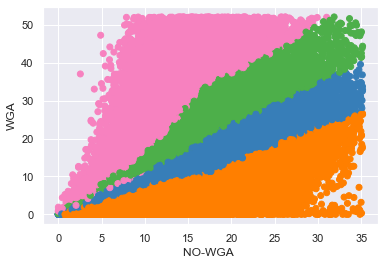

Number of clusters  5
BIC:  1786960.9167894279


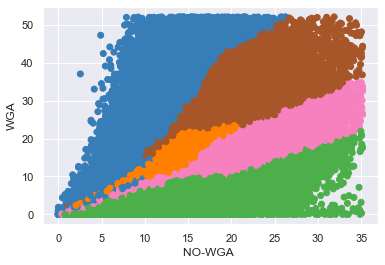

In [107]:
gmm_clustering(clusters=N_CLUSTERS, data=data)

## Two means + GC

In [108]:
data = make_data_array(wga_mu=wga_mu, 
                       no_wga_mu=no_wga_mu, gc=gc, 
                       use_ratio=False, use_gc=True)

data = np.array(data)

assert data.shape == (len(wga_mu), 3)

### KMeans

Number of clusters  2
Calinski score:  218389.32385444336
Davies score:  0.7999176246426883


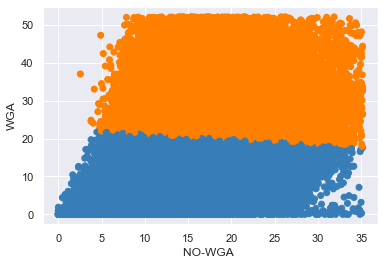

Number of clusters  3
Calinski score:  209528.1607223181
Davies score:  0.8705524494060652


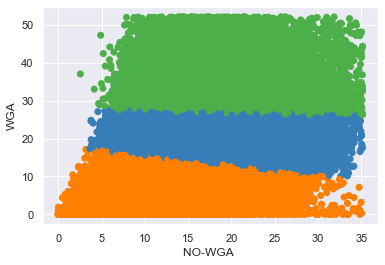

Number of clusters  4
Calinski score:  191914.88935096154
Davies score:  0.9493473539178237


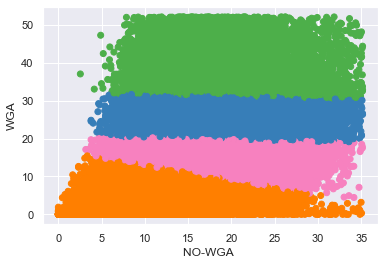

Number of clusters  5
Calinski score:  185074.28007727934
Davies score:  0.8981831804112869


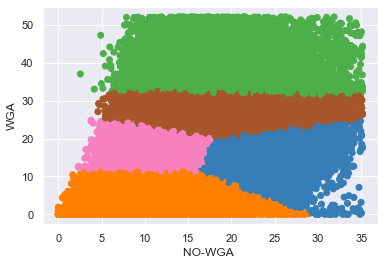

In [109]:
kmeans_clustering(clusters=N_CLUSTERS, data=data)
 

### GMM

Number of clusters  2
BIC:  2092320.7503889874


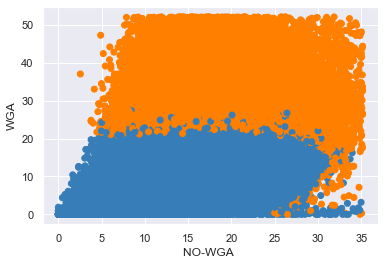

Number of clusters  3
BIC:  2087839.7983330467


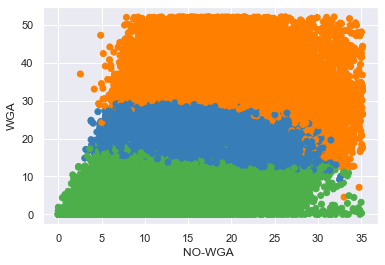

Number of clusters  4
BIC:  2087295.4034580823


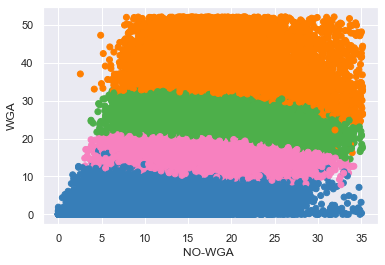

Number of clusters  5
BIC:  2084783.8656329839


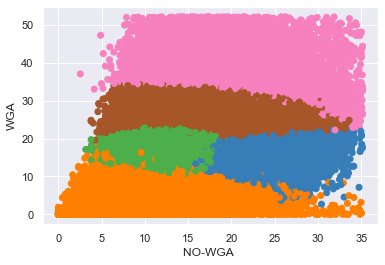

In [110]:
gmm_clustering(clusters=N_CLUSTERS, data=data)

## Two means + GC + Ratio

In [111]:
data = make_data_array(wga_mu=wga_mu, 
                       no_wga_mu=no_wga_mu, gc=gc, 
                       use_ratio=True, use_gc=True)

data = np.array(data)

assert data.shape == (len(wga_mu), 4)

## KMeans

Number of clusters  2
Calinski score:  218040.47067675696
Davies score:  0.8005916299263406


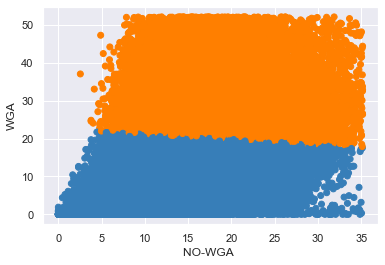

Number of clusters  3
Calinski score:  209019.33248445785
Davies score:  0.8714034685556658


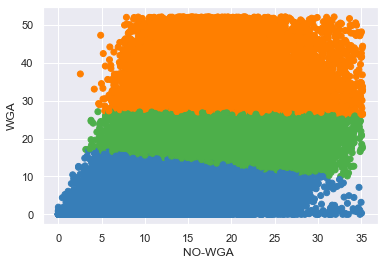

Number of clusters  4
Calinski score:  191349.22203387957
Davies score:  0.9478144715943108


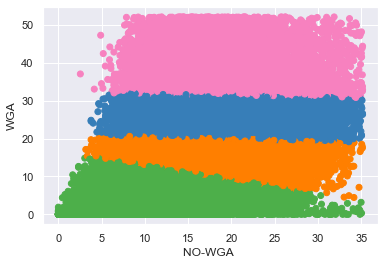

Number of clusters  5
Calinski score:  184517.00639546342
Davies score:  0.8970220182850008


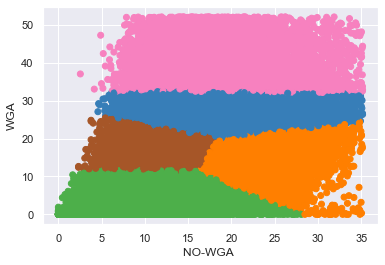

In [112]:
kmeans_clustering(clusters=N_CLUSTERS, data=data)

### GMM

Number of clusters  2
BIC:  1764632.1905069773


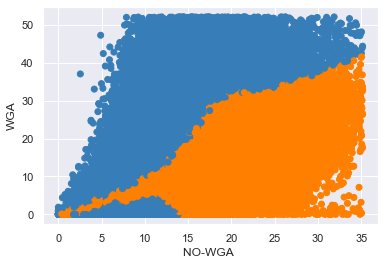

Number of clusters  3
BIC:  1621313.1909081442


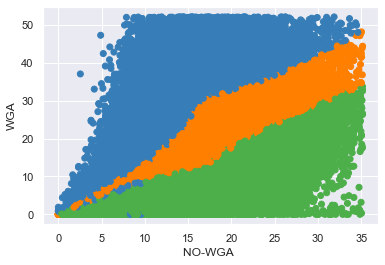

Number of clusters  4
BIC:  1514553.122349354


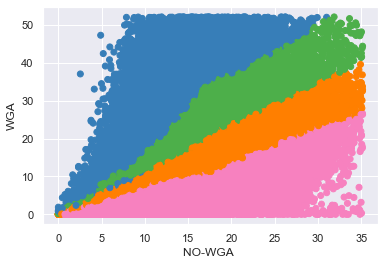

Number of clusters  5
BIC:  1439225.800776098


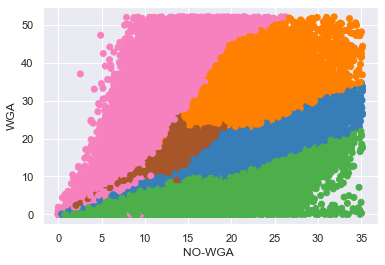

In [113]:
gmm_clustering(clusters=N_CLUSTERS, data=data)

Number of clusters  6
BIC:  1365710.3533789278


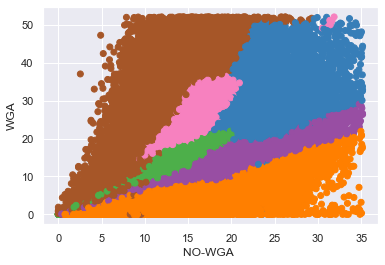

Number of clusters  10
BIC:  1175871.260173513


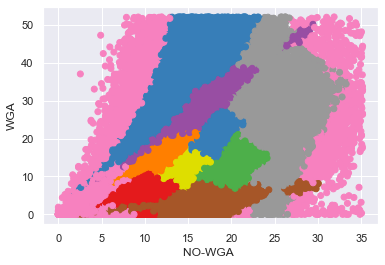

In [116]:
gmm_clustering(clusters=[6,10], data=data)